In [1]:
import re
import base64
import pickle
import numpy as np
import pandas as pd
from dateutil import parser
from tqdm import tqdm_notebook
from datetime import datetime, timedelta

In [2]:
def parse_bdays(x):
    # Year could be first or last; only consider years between 1970? and 2019
    birthday = re.compile(r"^([0-1]?[\d])/?([0-3]?[\d])/?((?:[1-2][09]\d\d))$")
    birthday2 = re.compile(r"^((?:[1-2][09]\d\d))/?([0-1]?[\d])/?([0-3]?[\d])$")
    birth = birthday.findall(x)
    birth2 = birthday2.findall(x)
    if birth2:
        a,b,c = birth2[0]
        if len(a) == 1:
            a = "0" + a
        if len(b) == 1:
            b = "0" + b
        if len(c) == 1:
            c = "0" + c
        if int(b) > 12:
            return a + c + b
        return a + b + c
    elif birth:
        a,b,c = birth[0]
        if len(a) == 1:
            a = "0" + a
        if len(b) == 1:
            b = "0" + b
        if len(c) == 2:
            c = "20" + c
        if int(a) > 12:
            return c + b + a
        return c + a + b
    else:
        return 0

In [39]:
parse_bdays('20171016')

'20171016'

In [4]:
def parse_string(x):
    if x != 0:
        string = base64.b64decode(x).decode("utf-8").replace("-", "")
        if string == "m" or string == "MALE" or string == "Male" or string == "male":
            return "M"
        elif string == "f" or string == "FEMALE" or string == "Female" or string == "female":
            return "F"
        else:
            return string
    else:
        return ""

def parse_gender(x):
    if x != "M" and x != "F":
        return 0
    else:
        return x

In [17]:
# df.created_at = df.created_at.apply(parser.parse) # takes a LONG time (write own if datetime is useful)

## Parse DOB M/F etc.

In [50]:
def parse_properties(df):
    # Clean
    # Val_boolean is never NaN when property_name is "PREMATURE"
    df = df.drop_duplicates()
    df.val_boolean = df.val_boolean.fillna(0)
    df.val_string = df.val_string.fillna("")

    # parse val_string values
    df.val_string = df.val_string.apply(parse_string)
    # Get rid of non M/F values
    mask1 = (df.property_name == "GENDER")
    gender = df.loc[mask1]
    df.loc[mask1, 'val_string'] = gender.val_string.apply(parse_gender)
    # df[df.property_name=="GENDER"] = df[(df.property_name == "GENDER") & (df.val_string.isin(["M", "F"]))]

    # parse bdays
    mask = (df.property_name == "BIRTHDATE")
    bdays = df.loc[mask]
    df.loc[mask, 'val_string'] = bdays.val_string.apply(parse_bdays)
    df = df.loc[df.val_string != 0]
    
    return df

In [51]:
# df = pd.read_csv("datapoint_pre_20190113_000000000000.csv", compression='gzip')
# df = parse_properties(df)
# df.to_csv("/Users/brodriguez/Documents/parsed_datapoint_pre_20190113.csv", compression="gzip")#, index=False
df = pd.read_csv('/Users/brodriguez/Documents/parsed_datapoint_pre_20190113.csv', compression='gzip', index_col=0)

/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [242]:
df[df.dsn == "AC000W002435762"].sort_values(by="created_at")

,dsn,created_at,property_name,base_type,val_boolean,val_string
382186,AC000W002435762,2018-07-16 16:45:37,GENDER,string,0.0,F
142528,AC000W002435762,2018-08-12 08:25:02,BIRTHDATE,string,0.0,20180722


In [56]:
df[(df.property_name == 'PREMATURE') & (df.dsn == 'AC000W000338379')]#.dsn.value_counts()

,dsn,created_at,property_name,base_type,val_boolean,val_string
316331,AC000W000338379,2017-07-24 04:09:43,PREMATURE,boolean,1.0,
316345,AC000W000338379,2017-05-05 04:38:04,PREMATURE,boolean,0.0,
316595,AC000W000338379,2017-08-21 22:38:29,PREMATURE,boolean,1.0,
319938,AC000W000338379,2017-08-21 22:39:53,PREMATURE,boolean,0.0,
322579,AC000W000338379,2017-03-05 01:28:40,PREMATURE,boolean,0.0,
322587,AC000W000338379,2017-07-13 16:01:04,PREMATURE,boolean,0.0,
324575,AC000W000338379,2017-04-19 00:34:29,PREMATURE,boolean,1.0,
326843,AC000W000338379,2017-12-13 05:02:51,PREMATURE,boolean,0.0,
330016,AC000W000338379,2017-04-08 02:10:18,PREMATURE,boolean,0.0,
331196,AC000W000338379,2017-08-21 22:42:53,PREMATURE,boolean,0.0,


In [22]:
# df_reg[df_reg.dsn == "AC000W000461567"]

In [68]:
df[df.dsn == "AC000W001123149"].sort_values(by="created_at")

,dsn,created_at,property_name,base_type,val_boolean,val_string
17499,AC000W001123149,2017-04-19 03:10:46,BIRTHDATE,string,0.0,20170414
559954,AC000W001123149,2017-07-28 02:20:55,GENDER,string,0.0,M
639253,AC000W001123149,2017-07-28 02:20:55,BIRTHDATE,string,0.0,19991231
327660,AC000W001123149,2017-07-28 02:20:56,PREMATURE,boolean,0.0,
55389,AC000W001123149,2017-07-28 08:37:35,BIRTHDATE,string,0.0,20170414


In [58]:
df[df.dsn == "AC000W000101826"].sort_values(by="created_at")

,dsn,created_at,property_name,base_type,val_boolean,val_string
28753,AC000W000101826,2017-02-24 05:27:25,BIRTHDATE,string,0.0,20150422
446682,AC000W000101826,2017-02-24 05:27:25,GENDER,string,0.0,F
349650,AC000W000101826,2017-02-25 21:38:22,PREMATURE,boolean,1.0,
54879,AC000W000101826,2017-02-25 21:38:58,BIRTHDATE,string,0.0,20160114
18072,AC000W000101826,2017-03-03 05:01:42,BIRTHDATE,string,0.0,20170302
631755,AC000W000101826,2017-03-03 21:12:56,GENDER,string,0.0,M
259331,AC000W000101826,2017-03-03 21:13:10,BIRTHDATE,string,0.0,20131129
27258,AC000W000101826,2017-03-17 05:50:33,BIRTHDATE,string,0.0,20170316
92301,AC000W000101826,2017-03-17 06:00:31,BIRTHDATE,string,0.0,20170317
328846,AC000W000101826,2017-03-17 20:42:47,PREMATURE,boolean,0.0,


In [59]:
df.dsn.value_counts()

AC000W000101826    350
AC000W000421783    317
AC000W000459365    257
AC000W000103796    163
AC000W000221576    150
AC000W000338379    147
AC000W000423872    144
AC000W000504805    129
AC000W000459666    109
AC000W000504874    106
AC000W000240434     71
AC000W002444313     66
AC000W000105359     53
AC000W002447092     48
AC000W000237669     46
AC000W000459559     41
AC000W001117455     40
AC000W000103509     38
AC000W001046245     38
AC000W002425973     37
AC000W000334764     33
AC000W002624776     32
AC000W001105306     29
AC000W000505040     29
AC000W001089814     29
AC000W000364643     27
AC000W001153564     27
AC000W002425866     26
AC000W000414716     25
AC000W001133459     23
                  ... 
AC000W001062017      1
AC000W001199635      1
AC000W001093771      1
AC000W000253625      1
AC000W001081555      1
AC000W001118257      1
AC000W000664724      1
AC000W000670706      1
AC000W002429498      1
AC000W001200928      1
AC000W000652025      1
AC000W000236663      1
AC000W00266

### Count invalid Gender values

In [612]:
count = 0
count_null = 0
for v in df[df.property_name == "GENDER"].val_string.values:
    if v == 0:
        count_null += 1
    elif v != "M" and v !="F":
        count += 1

print("Total # of values \t ",len(df[df.property_name == "GENDER"].val_string.values))        
print("# of invalid but not null",count)
print("# of null \t\t ",count_null)
print("percent of invalid values", 100*(count+count_null)/(count + count_null + len(df[df.property_name == "GENDER"].val_string.values)))

Total # of values 	  246000
# of invalid but not null 0
# of null 		  0
percent of invalid values 0.0


In [404]:
# df[(df.val_string != "") & (df.property_name == "GENDER")].val_string.value_counts() # After changing invalid strings to ""

In [822]:
df.val_string[df.property_name == "GENDER"].value_counts()

F    130200
M    115800
Name: val_string, dtype: int64

### Count invalid birthdate values

In [16]:
# Weird bday 
alpha = 0
count_na = 0
count_not_baby = 0
for b in df[df.property_name == "BIRTHDATE"].val_string.values:
    if b == 0:
        count_na += 1
    elif b[0] == "A" or b == "Invalid!":
        alpha += 1
    else:
        try:
            parser.parse(b)
        except:
            print(b)
#     elif b[:3] != "201":
#         try:
#             year = parser.parse(b).year
#             if  year > 2019 or year < 2017:
#                 count_not_baby += 1
# #                 print(parser.parse(b).date())
#         except:
#             if int(b[-4:]) < 1980 or int(b[-4:]) > 2019:
#                 count_not_baby += 1
#                 print(b)
#             else:
#                 try:
#                     num = b.replace("/","")
#                     if len(num) < 8:
#                         num = "0" + num
#                     parser.parse(num[:2] + "/" + num[2:4] + "/" + num[4:])
#                 except:
#                     print("couldn't parse: ", b)

10290030


In [425]:
print(len(df[df.property_name == "BIRTHDATE"].val_string.values))

342958


In [571]:
count_not_baby/342958*100

9.737052350433581

In [764]:
total = len(df[df.property_name == "BIRTHDATE"].val_string.values)
print("Total # of values \t ",total)        
print("# of alpha values \t ",alpha)
print("# of null \t\t ",count_na)
print("percent of invalid values", 100*(alpha+count_na)/(alpha+count_na + total))

Total # of values 	  282752
# of alpha values 	  0
# of null 		  0
percent of invalid values 0.012376806571730667


### Check bdays from last night

In [18]:
df_bday = pd.read_csv("unique_birthdate.csv")
# df_bday = df_bday[df_bday.birth_date != "0000-00-00"]

In [23]:
def buckets(x):
    year = int(x[:4])
    month = int(x[5:7])
    day = int(x[8:])
    if year == 0:
        return 0
    elif year > 2018:
        if month > 1 or day > 16:
            return 6
        else:
            return 1
    elif year < 1970:
        return 5
    elif year < 2013:
        return 3
    elif year < 2017:
        return 4
    elif year == 2017 and month < 8 and day < 17:
        return 2
    else:
        return 1
        

In [24]:
df_bday["buckets"] = df_bday.birth_date.apply(buckets)

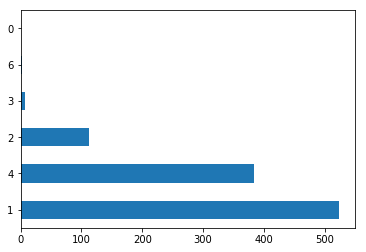

In [26]:
# df_bday.buckets.hist(grid=False, figsize=(15,8), align='mid', rwidth = .5)
df_bday.buckets.value_counts().plot.barh()

In [27]:
df_bday.buckets.value_counts()

1    524
4    384
2    112
3      8
6      3
0      1
Name: buckets, dtype: int64

In [28]:
total = 524+384+112+8+3+1
print("0-18 months\t\t\t", 524/total*100)
print("18-24 months\t\t\t", 112/total*100)
print("2-6 years\t\t\t", 384/total*100)
print("6-50 years\t\t\t", 8/total*100)
print("Birthday before 1970's\t\t", 0/total*100)
print("Birthday after Jan 16 2019\t", 3/total*100)
print("no date\t\t\t\t", 1/total*100)

0-18 months			 50.775193798449614
18-24 months			 10.852713178294573
2-6 years			 37.2093023255814
6-50 years			 0.7751937984496124
Birthday before 1970's		 0.0
Birthday after Jan 16 2019	 0.29069767441860467
no date				 0.09689922480620156


## Parse Registration

In [11]:
def date_registered(x):
    if x == 0:
        return " "
    months = {"Jan":"01","Feb":"02","Mar":"03",
          "Apr":"04","May":"05","Jun":"06",
          "Jul":"07","Aug":"08","Sep":"09",
          "Oct":"10","Nov":"11","Dec":"12"}
    return x[-4:] + "-" + months[x[4:7]] + "-" + x[8:10] + " " + x[11:19] # str vs datetime
#     return datetime(int(x[-4:]), int(months[x[4:7]]), int(x[8:10]), int(x[11:13]), int(x[14:16]), int(x[17:19]))

In [12]:
def parse_registration(df_reg):
    # Clean registration data
    df_reg = df_reg.drop_duplicates().fillna(0)
    df_reg.registered_at = df_reg.registered_at.apply(date_registered)
    df_reg = df_reg[df_reg.ayla_uuid != 0]
    
    return df_reg

In [97]:
# df_reg = pd.read_csv("registration_pre_20190113_000000000000.csv", compression='gzip')
# df_reg = parse_registration(df_reg)
# df_reg.to_csv("parsed_registration_pre_20190113.csv", compression="gzip"), index=False
df_reg = pd.read_csv('/Users/brodriguez/Documents/parsed_registration_pre_20190113.csv', compression='gzip', index_col=0)


In [60]:
df_reg.dsn.value_counts()

AC000W001123149    418
AC000W000421783    328
AC000W000101826    287
AC000W000423451    231
AC000W000459365    199
AC000W000323720    196
AC000W002427778    182
AC000W000336117    163
AC000W000423872    136
AC000W001129969    135
AC000W001063394    130
AC000W002502145    122
AC000W000504805    114
AC000W001127216    111
AC000W000418004    106
AC000W000103796    105
AC000W000504204    102
AC000W001139771     91
AC000W000459666     89
AC000W002496039     87
AC000W001145133     85
AC000W000504874     84
AC000W002630625     81
AC000W000334764     74
AC000W001123426     72
AC000W002441880     68
AC000W001133255     68
AC000W002637778     68
AC000W003420047     67
AC000W001123132     67
                  ... 
AC000W002641296      1
AC000W001183789      1
AC000W001215749      1
AC000W000666119      1
AC000W002446808      1
AC000W001051363      1
AC000W001062167      1
AC000W001125926      1
AC000W001055023      1
AC000W001211696      1
AC000W001135201      1
AC000W002664279      1
AC000W00251

In [100]:
def bday_to_month_yr(x):
    if len(x) < 10:
        return ''
    if (int(x[:4]) < 2015) or (int(x[:4]) > 2019):
        return ''
    return datetime(int(x[:4]),int(x[5:7]),int(x[8:10]))
df_reg['month_yr'] = df_reg.registered_at.apply(bday_to_month_yr)

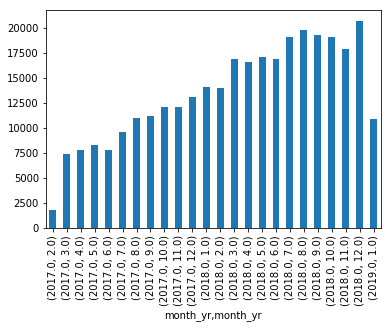

In [21]:
df_reg.groupby([df_reg.month_yr.dt.year, df_reg.month_yr.dt.month]).dsn.count().plot(kind="bar")


In [67]:
# Clean registration (get rid of registrations within days of each other)

# for each dsn/alya_id combo: find registration just before gap (only keep those)
# Each dsn: get set of ayla_uuid & loop through, for each 
# Try saving each of these in a df

# pass in df for a given dsn and ayla uuid, size of gap 9 months 270 days
def find_gaps_from_df(df_all, size_of_gap): 
    '''Find the date just before a gap in data of the size given'''
    # fillna(size_of_gap) includes the very last day of use as a day before a gap
    gaps = df_all.month_yr.diff(-1).fillna(size_of_gap).abs().ge(size_of_gap)
    day_before = df_all[gaps]
    return list(day_before.index)

gaps_dsn = 'AC000W001123149'
gaps_ayla = 'fec684b0-24ac-11e7-bac1-0e9382159dc5'
gap_size = size_of_gap=pd.Timedelta(270, 'D')
gap_df = df_reg.loc[(df_reg.dsn == gaps_dsn) & (df_reg.ayla_uuid == gaps_ayla)].sort_values(by="registered_at")

find_gaps_from_df(gap_df, gap_size) # indices of registrations to consider


[406459]

In [101]:
df_reg_new_index = df_reg.loc[df_reg.ayla_uuid != '0'].reset_index(drop=True)
all_indices = []
gap_size = size_of_gap=pd.Timedelta(270, 'D')
for dsn in tqdm_notebook(set(df_reg_new_index.dsn.values)):
    for ayla_id in set(df_reg_new_index[df_reg_new_index.dsn == dsn].ayla_uuid.values):
        gap_df = df_reg_new_index.loc[(df_reg_new_index.dsn == dsn) & (df_reg_new_index.ayla_uuid == ayla_id)].sort_values(by="registered_at")
        all_indices += find_gaps_from_df(gap_df, gap_size)

In [105]:
removed_duplicates = df_reg_new_index.iloc[sorted(all_indices)]

In [118]:
removed_duplicates[removed_duplicates.dsn == 'AC000W000421783'].sort_values(by='registered_at')

,dsn,ayla_uuid,registered_at,month_yr
276531,AC000W000421783,efc5a850-f9dd-11e6-bcae-0e9382159dc5,2017-02-23 15:38:37,2017-02-23
270194,AC000W000421783,e353c2b0-fec3-11e6-9e57-0ab553feed59,2017-03-01 21:15:10,2017-03-01
213527,AC000W000421783,7631f494-ff64-11e6-9bb1-0ee51d704787,2017-03-02 16:36:10,2017-03-02
209766,AC000W000421783,6f4d50e2-ff6e-11e6-a372-0ee51d704787,2017-03-02 17:35:57,2017-03-02
206631,AC000W000421783,698739e6-ff75-11e6-b9f2-0ab3f06930bb,2017-03-02 18:26:05,2017-03-02
176296,AC000W000421783,30249fbc-08db-11e7-b1f1-0ab3f06930bb,2017-03-14 17:27:47,2017-03-14
182635,AC000W000421783,3c5242a2-feb4-11e6-a372-0ee51d704787,2017-03-15 22:44:09,2017-03-15
158441,AC000W000421783,0d7e2956-101a-11e7-8a22-0ee51d704787,2017-03-23 22:59:57,2017-03-23
258860,AC000W000421783,cd4d85dc-1e17-11e7-82f4-0e9382159dc5,2017-04-10 19:16:41,2017-04-10
272240,AC000W000421783,e7433bfe-4544-11e7-b386-0ab3f06930bb,2017-05-30 20:05:40,2017-05-30


In [ ]:
# From brief observation, it looks like ayla Ids that start 
#     with 1a2039d9:: are devices that are being tested in the office.. NOT TRUE
# maybe some devices are used in testing but also belongm to a customer @ some point

In [120]:
count = 0
for id_ in removed_duplicates.ayla_uuid.values:
    if "1a2039d9::" in id_:
        count +=1
print(count, len(removed_duplicates.ayla_uuid.values))

2238 273538


In [113]:
removed_duplicates.dsn.value_counts()

AC000W000421783    235
AC000W000101826    166
AC000W000423872     74
AC000W000459365     70
AC000W000504805     68
AC000W000103796     63
AC000W000423451     49
AC000W000255174     43
AC000W002502145     38
AC000W000338379     36
AC000W000504874     36
AC000W001063394     35
AC000W002637778     35
AC000W000459666     35
AC000W000103509     31
AC000W002496039     29
AC000W000105359     22
AC000W000505040     22
AC000W001067728     21
AC000W001046245     20
AC000W000334764     19
AC000W002460326     18
AC000W000422774     18
AC000W002444313     17
AC000W000336117     17
AC000W002445690     16
AC000W000505016     16
AC000W002498467     15
AC000W000021659     13
AC000W001202633     13
                  ... 
AC000W002441399      1
AC000W002518621      1
AC000W002672618      1
AC000W001067941      1
AC000W002575039      1
AC000W003389772      1
AC000W000333316      1
AC000W000424169      1
AC000W003461249      1
AC000W000449896      1
AC000W001108580      1
AC000W002601963      1
AC000W00120

In [110]:
df_reg[df_reg.dsn == "AC000W000421783"].sort_values(by="registered_at")

,dsn,ayla_uuid,registered_at,month_yr
12742,AC000W000421783,0,,NaT
395639,AC000W000421783,efc5a850-f9dd-11e6-bcae-0e9382159dc5,2017-02-23 15:38:37,2017-02-23
265841,AC000W000421783,3c5242a2-feb4-11e6-a372-0ee51d704787,2017-03-01 19:30:52,2017-03-01
386925,AC000W000421783,e353c2b0-fec3-11e6-9e57-0ab553feed59,2017-03-01 21:15:10,2017-03-01
308610,AC000W000421783,7631f494-ff64-11e6-9bb1-0ee51d704787,2017-03-02 16:36:10,2017-03-02
303428,AC000W000421783,6f4d50e2-ff6e-11e6-a372-0ee51d704787,2017-03-02 17:35:57,2017-03-02
299123,AC000W000421783,698739e6-ff75-11e6-b9f2-0ab3f06930bb,2017-03-02 18:26:05,2017-03-02
265840,AC000W000421783,3c5242a2-feb4-11e6-a372-0ee51d704787,2017-03-02 22:19:24,2017-03-02
257095,AC000W000421783,30249fbc-08db-11e7-b1f1-0ab3f06930bb,2017-03-14 17:27:47,2017-03-14
265842,AC000W000421783,3c5242a2-feb4-11e6-a372-0ee51d704787,2017-03-15 22:44:09,2017-03-15


In [111]:
df[df.dsn == 'AC000W000421783'].sort_values(by='created_at')

,dsn,created_at,property_name,base_type,val_boolean,val_string
30617,AC000W000421783,2017-02-23 15:38:45,BIRTHDATE,string,0.0,20170223
156002,AC000W000421783,2017-03-01 19:31:12,BIRTHDATE,string,0.0,20170226
105988,AC000W000421783,2017-03-01 21:15:21,BIRTHDATE,string,0.0,20170401
75794,AC000W000421783,2017-03-02 16:36:20,BIRTHDATE,string,0.0,20170302
606695,AC000W000421783,2017-03-09 21:27:37,GENDER,string,0.0,M
656711,AC000W000421783,2017-03-09 21:27:37,BIRTHDATE,string,0.0,19991231
290635,AC000W000421783,2017-03-14 17:27:57,BIRTHDATE,string,0.0,20170314
193307,AC000W000421783,2017-03-15 22:44:20,BIRTHDATE,string,0.0,20170315
646298,AC000W000421783,2017-03-22 22:13:10,BIRTHDATE,string,0.0,19991231
49605,AC000W000421783,2017-03-23 23:00:05,BIRTHDATE,string,0.0,20170323


In [158]:
df_combined.dsn.value_counts()

AC000W000103039    6
AC000W001097747    6
AC000W000422628    6
AC000W000327314    6
AC000W002426370    5
AC000W002604536    5
AC000W003389763    5
AC000W000670502    4
AC000W000421078    4
AC000W001209852    4
AC000W001060462    4
AC000W001092930    4
AC000W000238622    4
AC000W001039313    4
AC000W000460048    4
AC000W001054429    4
AC000W000238472    4
AC000W001042941    4
AC000W000443137    4
AC000W000363755    4
AC000W001053962    4
AC000W000239620    4
AC000W001085660    4
AC000W001054070    4
AC000W001141499    4
AC000W002436656    4
AC000W001084604    4
AC000W000253536    4
AC000W000652562    4
AC000W001082386    4
                  ..
AC000W001117725    1
AC000W002669053    1
AC000W003420485    1
AC000W002581331    1
AC000W000256019    1
AC000W001116465    1
AC000W000332102    1
AC000W001150612    1
AC000W002623950    1
AC000W001042884    1
AC000W001098971    1
AC000W000366676    1
AC000W001126911    1
AC000W001089795    1
AC000W000234653    1
AC000W002584809    1
AC000W0026008

In [202]:
(df_combined.dsn.value_counts() > 1).value_counts()

False    9924
True     2144
Name: dsn, dtype: int64

## Combine registration and baby info

In [126]:
reg_dsns = set(removed_duplicates.dsn.values)
profile_dsns = set(df.dsn.values)
reg_and_profile_dsns = reg_dsns.intersection(list(profile_dsns))
print(len(reg_and_profile_dsns))

222774


In [238]:
len(reg_dsns)

230238

In [127]:
dsns_16000 = pickle.load(open("rollups_dsns.p", "rb"))
inclusion_dsns = list(set(dsns_16000).intersection(list(reg_and_profile_dsns)))

In [249]:
df_combined_new[df_combined_new.dsn == 'AC000W000103039'].sort_values(by='registered_at')

,dsn,registered_at,birthdate,gender,premature,ayla_uuid
2271,AC000W000103039,2017-12-29 21:30:30,20170919,F,,6bedabd2-ecde-11e7-acd2-0ef7636f67fa
2270,AC000W000103039,2018-03-30 04:21:07,19991231,M,0,c6634662-33b0-11e8-aabb-0ac49f1ecf36
2269,AC000W000103039,2018-08-31 21:05:01,20180903,M,0,e00c87b8-35cc-11e8-836c-0e3fb1df70d2
2268,AC000W000103039,2019-01-03 01:56:37,,,,1a2039d9::eBn6Kl4BHZOUNEzlamE4yQwFB072
2267,AC000W000103039,2019-01-03 02:19:04,20181231,F,,48fd5234-afbc-11e8-a795-0ab3f06930bb
2266,AC000W000103039,2019-01-05 21:40:23,,,,6edb4e94-1131-11e9-a85d-0ab6f6ed5598


In [232]:
df[df.dsn == 'AC000W000421783'].sort_values(by='created_at')

,dsn,created_at,property_name,base_type,val_boolean,val_string
30617,AC000W000421783,2017-02-23 15:38:45,BIRTHDATE,string,0.0,20170223
156002,AC000W000421783,2017-03-01 19:31:12,BIRTHDATE,string,0.0,20170226
105988,AC000W000421783,2017-03-01 21:15:21,BIRTHDATE,string,0.0,20170401
75794,AC000W000421783,2017-03-02 16:36:20,BIRTHDATE,string,0.0,20170302
606695,AC000W000421783,2017-03-09 21:27:37,GENDER,string,0.0,M
656711,AC000W000421783,2017-03-09 21:27:37,BIRTHDATE,string,0.0,19991231
290635,AC000W000421783,2017-03-14 17:27:57,BIRTHDATE,string,0.0,20170314
193307,AC000W000421783,2017-03-15 22:44:20,BIRTHDATE,string,0.0,20170315
646298,AC000W000421783,2017-03-22 22:13:10,BIRTHDATE,string,0.0,19991231
49605,AC000W000421783,2017-03-23 23:00:05,BIRTHDATE,string,0.0,20170323


In [213]:
# need to rethink this given that i removed a lot of duplicates
rows = []
t = timedelta(minutes=5)
for dsn in tqdm_notebook(inclusion_dsns):
    bday, gender, premature = None, None, None
    registration = list(removed_duplicates[removed_duplicates.dsn == dsn].registered_at.values)
    for reg_time in registration:
        ayla_uuid = removed_duplicates[(removed_duplicates.dsn == dsn) & (removed_duplicates.registered_at == reg_time)].ayla_uuid.values[0] # What happens if there are multiple registrations w/ exact same time??
        
        reg_datetime = datetime(int(reg_time[:4]), int(reg_time[5:7]), int(reg_time[8:10]), int(reg_time[11:13]), int(reg_time[14:16]), int(reg_time[17:]))
        pre = str(reg_datetime - t)
        post = str(reg_datetime + t)
        properties = df[(df.dsn == dsn) & (df.created_at > pre) & (df.created_at < post)].sort_values(by='created_at') #   want created_at to be close to reg_time
        df_bday = properties[properties.property_name == 'BIRTHDATE']
        df_gender = properties[properties.property_name == 'GENDER']
        df_premature = properties[properties.property_name == 'PREMATURE']
        
        if df_bday.shape[0] != 0:
            bday = df_bday.iloc[-1].val_string # the last BIRTHDATE entry
            
        if df_gender.shape[0] != 0:
            gender = df_gender.iloc[-1].val_string # the last GENDER entry
            
        if df_premature.shape[0] != 0:
            premature = df_premature.iloc[-1].val_boolean # the last PREMATURE entry
            
        
        rows.append((dsn, reg_time, bday, gender, premature, ayla_uuid))
column_names = ['dsn', 'registered_at', 'birthdate', 'gender', 'premature', 'ayla_uuid']
df_combined = pd.DataFrame(rows, columns=column_names)

In [245]:
def combined_reg_bday(df_reg, df):    
    new_rows = []
    for dsn in tqdm_notebook(inclusion_dsns):
        bday, gender, premature = '', '', ''
        registration = list(df_reg[df_reg.dsn == dsn].registered_at.values)

        prev_reg_time = '2020-01-01'
        for reg_time in sorted(registration, reverse=True):
            ayla_uuid = df_reg[(df_reg.dsn == dsn) & (df_reg.registered_at == reg_time)].ayla_uuid.values[0]
            
            reg_datetime = datetime(int(reg_time[:4]), int(reg_time[5:7]), int(reg_time[8:10]), int(reg_time[11:13]), int(reg_time[14:16]), int(reg_time[17:]))
            plus_21_days = str(reg_datetime + timedelta(days = 21))

            properties = df[(df.dsn == dsn) & (df.created_at >= reg_time[:10]) & (df.created_at < prev_reg_time)].sort_values(by='created_at') # min(prev_reg_time, plus_21_days)
            df_bday = properties[properties.property_name == 'BIRTHDATE']
            df_gender = properties[properties.property_name == 'GENDER']
            df_premature = properties[properties.property_name == 'PREMATURE']

            if df_bday.shape[0] != 0:
                bday = df_bday.iloc[-1].val_string # the last BIRTHDATE entry

            if df_gender.shape[0] != 0:
                gender = df_gender.iloc[-1].val_string # the last GENDER entry

            if df_premature.shape[0] != 0:
                premature = df_premature.iloc[-1].val_boolean # the last PREMATURE entry

            # if there's no bday move on, if there is, add row and then reset? save list of bdays and ayla ids?
#             if (bday is not None): #& (bday not in prev_bdays):
            
            # Want record of the ayla id even if there is no other info
            new_rows.append((dsn, reg_time, bday, gender, premature, ayla_uuid))
            bday, gender, premature = '', '', ''

            prev_reg_time = reg_time
            
    column_names = ['dsn', 'registered_at', 'birthdate', 'gender', 'premature', 'ayla_uuid']
    df_combined_new = pd.DataFrame(new_rows, columns=column_names)
    return df_combined_new

In [246]:
df_combined_new = combined_reg_bday(removed_duplicates[removed_duplicates.ayla_uuid != '0'], df)
# df_combined_new.sort_values(by='registered_at') # Should clean registration 1st (get rid of registrations on the same day)


In [250]:
pickle.dump(df_combined_new, open('reg_baby_data_test.p', 'wb'))

In [37]:
df_combined.sort_values(by=['dsn','registered_at'])

,dsn,registered_at,birthdate,gender,premature,ayla_uuid
1958,AC000W000020032,2017-04-07 02:37:01,20170213,F,1.0,8a3b93ec-1b38-11e7-b952-0ab553feed59
1956,AC000W000020032,2018-11-20 00:01:30,None,None,NaN,4a3d28c8-ec56-11e8-9196-0af9b264a1d6
1957,AC000W000020032,2018-11-20 00:13:23,19991231,M,0.0,4a3d28c8-ec56-11e8-9196-0af9b264a1d6
16792,AC000W000020243,2017-11-02 02:31:59,20171030,F,NaN,2d89c6d2-9452-11e5-b4e1-0adb0625a587
16793,AC000W000020243,2018-02-10 06:53:27,20171030,F,NaN,2d89c6d2-9452-11e5-b4e1-0adb0625a587
6920,AC000W000020254,2017-09-15 00:08:57,20170911,None,NaN,65ace1f2-99a5-11e7-912a-0ee51d704787
16596,AC000W000020336,2017-03-06 03:29:30,20170225,None,NaN,85a55506-021b-11e7-9d04-0e9382159dc5
10401,AC000W000020373,2018-12-28 03:43:25,20181015,M,NaN,e65cfb2a-0a51-11e9-bca8-0a1911b5da32
15345,AC000W000020408,2017-04-25 00:46:44,20170418,F,1.0,367628d4-2926-11e7-b86c-0ab3f06930bb
15346,AC000W000020408,2017-04-26 22:27:33,19991231,M,0.0,367628d4-2926-11e7-b86c-0ab3f06930bb


In [36]:
df_combined[df_combined.dsn == 'AC000W001088786'].sort_values(by='registered_at')

,dsn,registered_at,birthdate,gender,premature,ayla_uuid
15904,AC000W001088786,2017-06-04 00:02:42,20160716,None,NaN,4b4be3d2-507a-11e6-a553-0ee51d704787
15905,AC000W001088786,2017-06-27 04:46:53,20160716,M,0.0,4b4be3d2-507a-11e6-a553-0ee51d704787
15922,AC000W001088786,2018-01-10 03:51:27,20160716,M,0.0,c1d99efe-4827-11e7-948a-0ab553feed59
15921,AC000W001088786,2018-01-12 04:39:38,20160716,M,0.0,c1d99efe-4827-11e7-948a-0ab553feed59
15913,AC000W001088786,2018-01-17 22:42:56,20160716,M,0.0,4b4be3d2-507a-11e6-a553-0ee51d704787
15923,AC000W001088786,2018-02-05 06:58:14,20160716,M,0.0,c1d99efe-4827-11e7-948a-0ab553feed59
15914,AC000W001088786,2018-02-05 08:39:08,20160716,M,0.0,4b4be3d2-507a-11e6-a553-0ee51d704787
15919,AC000W001088786,2018-02-14 03:14:21,20160716,M,0.0,c1d99efe-4827-11e7-948a-0ab553feed59
15912,AC000W001088786,2018-02-14 03:57:38,20160716,M,0.0,4b4be3d2-507a-11e6-a553-0ee51d704787
15920,AC000W001088786,2018-02-14 04:07:08,20160716,M,0.0,c1d99efe-4827-11e7-948a-0ab553feed59


In [119]:
reg_time = '2018-08-31 21:05:31'
reg_datetime = datetime(int(reg_time[:4]), int(reg_time[5:7]), int(reg_time[8:10]), int(reg_time[11:13]), int(reg_time[14:16]), int(reg_time[17:]))
# pre = reg_datetime - t
# post = reg_datetime + t
        
str(reg_datetime - timedelta(seconds=1))

'2018-08-31 21:05:30'

## Find out how many devices have been used by multiple babies

In [160]:
feb = df_reg[df_reg.registered_at < "2017-03"]
feb_dsns = set(feb.dsn.values)
yr_later = df_reg[df_reg.registered_at > "2018-02"]
yr_later_dsns = set(yr_later.dsn.values)
two_months = df_reg[df_reg.registered_at > "2017-04-23"]
two_months_dsns = list(two_months.dsn.values)

In [88]:
intersection2 = set(feb_dsns).intersection(two_months_dsns)
print(len(intersection2))

486 {'AC000W001044146', 'AC000W000104114', 'AC000W000096779', 'AC000W000021319', 'AC000W000328636', 'AC000W001041192', 'AC000W000020793', 'AC000W000417810', 'AC000W000097772', 'AC000W001085231', 'AC000W000365959', 'AC000W001040518', 'AC000W000505843', 'AC000W001125090', 'AC000W000419370', 'AC000W000104167', 'AC000W000097648', 'AC000W000659679', 'AC000W000240408', 'AC000W000098677', 'AC000W000022413', 'AC000W001121380', 'AC000W000022288', 'AC000W000323516', 'AC000W000455330', 'AC000W000449799', 'AC000W001123279', 'AC000W001039748', 'AC000W001086575', 'AC000W000331195', 'AC000W001178880', 'AC000W001086418', 'AC000W001085331', 'AC000W001044930', 'AC000W001082223', 'AC000W001042059', 'AC000W000420817', 'AC000W001087711', 'AC000W000234905', 'AC000W001087059', 'AC000W001086397', 'AC000W000328901', 'AC000W001086421', 'AC000W001085190', 'AC000W001127804', 'AC000W000664664', 'AC000W001085237', 'AC000W001121901', 'AC000W001179827', 'AC000W000460560', 'AC000W000419862', 'AC000W001127666', 'AC000W

In [77]:
intersection = set(feb_dsns).intersection(yr_later_dsns)
len(intersection)

267

In [161]:
print(len(feb_dsns), len(yr_later_dsns))

1645 157170


In [81]:
print(intersection)

{'AC000W001044146', 'AC000W000104114', 'AC000W000096779', 'AC000W000021319', 'AC000W000328636', 'AC000W001041192', 'AC000W000020793', 'AC000W000417810', 'AC000W000097772', 'AC000W001085231', 'AC000W000365959', 'AC000W001040518', 'AC000W000505843', 'AC000W001125090', 'AC000W000419370', 'AC000W000104167', 'AC000W000097648', 'AC000W000659679', 'AC000W000240408', 'AC000W000098677', 'AC000W000022413', 'AC000W001121380', 'AC000W000022288', 'AC000W000323516', 'AC000W000455330', 'AC000W000449799', 'AC000W001123279', 'AC000W001039748', 'AC000W001086575', 'AC000W000331195', 'AC000W001178880', 'AC000W001086418', 'AC000W001085331', 'AC000W001044930', 'AC000W001082223', 'AC000W001042059', 'AC000W000420817', 'AC000W001087711', 'AC000W000234905', 'AC000W001087059', 'AC000W001086397', 'AC000W000328901', 'AC000W001086421', 'AC000W001085190', 'AC000W001127804', 'AC000W000664664', 'AC000W001085237', 'AC000W001121901', 'AC000W001179827', 'AC000W000460560', 'AC000W000419862', 'AC000W001127666', 'AC000W0010

In [23]:
# 'AC000W000338754' in list(df_reg.dsn.values)
# Intersection of registered dsn's and dsns in the 16000
my_list = pickle.load(open("rollups_dsns.p", "rb"))
l2 = set(my_list).intersection(list(df_reg.dsn.values))

In [24]:
len(l2)

12649

In [25]:
len(my_list)

15997

In [166]:
df_reg.dsn.value_counts()

AC000W001123149    417
AC000W000421783    327
AC000W000101826    286
AC000W000423451    230
AC000W000459365    198
AC000W000323720    195
AC000W002427778    181
AC000W000336117    162
AC000W000423872    135
AC000W001129969    134
AC000W001063394    129
AC000W002502145    121
AC000W000504805    113
AC000W001127216    110
AC000W000418004    105
AC000W000103796    104
AC000W000504204    101
AC000W001139771     90
AC000W000459666     88
AC000W002496039     86
AC000W001145133     84
AC000W000504874     83
AC000W002630625     80
AC000W000334764     73
AC000W001123426     71
AC000W002637778     67
AC000W001133255     67
AC000W002441880     67
AC000W001123132     66
AC000W003420047     66
                  ... 
AC000W002498432      1
AC000W002587878      1
AC000W002502470      1
AC000W001056132      1
AC000W002611610      1
AC000W001131585      1
AC000W002440574      1
AC000W002453956      1
AC000W002674218      1
AC000W003379001      1
AC000W002497037      1
AC000W000253094      1
AC000W00251

In [170]:
a = df_reg.dsn.value_counts().values 
len(a[a<4])

222822

In [178]:
df_reg.dsn.value_counts().index[-222823]

'AC000W000232311'

## Names

In [17]:
df_names = pd.read_csv("baby_names_datapoint.csv")

In [134]:
df_names[df_names.dsn == 'AC000W002577819']

,dsn,baby_name,created_at,updated_at
112257,AC000W002577819,Rylie,Tue Feb 27 01:03:56 UTC 2018,Tue Feb 27 01:03:56 UTC 2018
416551,AC000W002577819,Colt,Sat Jan 27 04:06:57 UTC 2018,Sat Jan 27 04:06:57 UTC 2018


In [35]:
df_names[df_names.baby_name == 'Asshol']

,dsn,baby_name,created_at,updated_at
3249,AC000W001066309,Asshol,Sat Mar 24 05:23:13 UTC 2018,Sat Mar 24 05:23:13 UTC 2018
7312,AC000W001066309,Asshol,Sat Mar 24 05:23:17 UTC 2018,Sat Mar 24 05:23:17 UTC 2018
169493,AC000W002501362,Asshol,Fri Oct 26 02:59:37 UTC 2018,Fri Oct 26 02:59:37 UTC 2018
173027,AC000W002501362,Asshol,Fri Oct 26 03:00:02 UTC 2018,Fri Oct 26 03:00:02 UTC 2018


In [38]:
df_names[df_names.dsn == 'AC000W001066309'].sort_values(by="created_at")

,dsn,baby_name,created_at,updated_at
702184,AC000W001066309,NaN,Sat Mar 24 05:16:34 UTC 2018,Sat Mar 24 05:16:34 UTC 2018
7319,AC000W001066309,C,Sat Mar 24 05:16:41 UTC 2018,Sat Mar 24 05:16:41 UTC 2018
3244,AC000W001066309,Co,Sat Mar 24 05:16:42 UTC 2018,Sat Mar 24 05:16:42 UTC 2018
7318,AC000W001066309,Col,Sat Mar 24 05:16:42 UTC 2018,Sat Mar 24 05:16:42 UTC 2018
7308,AC000W001066309,Colt,Sat Mar 24 05:16:43 UTC 2018,Sat Mar 24 05:16:43 UTC 2018
3237,AC000W001066309,olt,Sat Mar 24 05:23:04 UTC 2018,Sat Mar 24 05:23:04 UTC 2018
3234,AC000W001066309,ol,Sat Mar 24 05:23:07 UTC 2018,Sat Mar 24 05:23:07 UTC 2018
702187,AC000W001066309,NaN,Sat Mar 24 05:23:08 UTC 2018,Sat Mar 24 05:23:08 UTC 2018
7313,AC000W001066309,o,Sat Mar 24 05:23:08 UTC 2018,Sat Mar 24 05:23:08 UTC 2018
7309,AC000W001066309,As,Sat Mar 24 05:23:10 UTC 2018,Sat Mar 24 05:23:10 UTC 2018


In [94]:
df_names[df_names.dsn == 'AC000W002501362']

,dsn,baby_name,created_at,updated_at
169456,AC000W002501362,Cha,Fri Oct 26 02:59:16 UTC 2018,Fri Oct 26 02:59:16 UTC 2018
169457,AC000W002501362,Assholey,Fri Oct 26 02:59:56 UTC 2018,Fri Oct 26 02:59:56 UTC 2018
169461,AC000W002501362,Charl,Fri Oct 26 02:59:15 UTC 2018,Fri Oct 26 02:59:15 UTC 2018
169464,AC000W002501362,Charlot,Fri Oct 26 02:59:15 UTC 2018,Fri Oct 26 02:59:15 UTC 2018
169466,AC000W002501362,Asshole BAB,Fri Oct 26 02:59:40 UTC 2018,Fri Oct 26 02:59:40 UTC 2018
169475,AC000W002501362,Ch,Fri Oct 26 02:59:16 UTC 2018,Fri Oct 26 02:59:16 UTC 2018
169476,AC000W002501362,Asshole BAB,Fri Oct 26 02:59:39 UTC 2018,Fri Oct 26 02:59:39 UTC 2018
169478,AC000W002501362,Asshole BA,Fri Oct 26 02:59:39 UTC 2018,Fri Oct 26 02:59:39 UTC 2018
169479,AC000W002501362,Asshole By,Fri Oct 26 02:59:55 UTC 2018,Fri Oct 26 02:59:55 UTC 2018
169482,AC000W002501362,Asshole B,Fri Oct 26 02:59:39 UTC 2018,Fri Oct 26 02:59:39 UTC 2018
